# Gendist V1.0
## Rotation trenches

* Convert weights to tensorflow dataset
* Train on the full circle to get the baseline
* Use CNN already!!

* Compare snapshot-ensemble v.s. "original" adam-sgd.
* Try 500 rotations

In [1]:
import os
from datetime import datetime

date_str = datetime.now().strftime("%y%m%d%H%M")
path_base = f"exp-{date_str}"

path_base = os.path.join("outputs", path_base)
path_output = os.path.join(path_base, "output")
path_logs = os.path.join(path_base, "logs")

print(path_base)

outputs/exp-2203211744


In [2]:
os.mkdir(path_base)
os.mkdir(path_output)
os.mkdir(path_logs)

In [2]:
import os
path_base = os.path.join("outputs", "exp-2203211744")
path_output = os.path.join(path_base, "output")
path_logs = os.path.join(path_base, "logs")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import jax
import optax
import dojax
import pickle
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from augly import image
from sklearn.decomposition import PCA
from flax import serialization
from multiprocessing import Pool
from loguru import logger

In [5]:
from tqdm.notebook import tqdm

In [6]:
import gendist
from gendist import training, processing, models

In [7]:
from gendist.models import MLPDataV1
from gendist.processing import flat_and_concat_params

In [8]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [9]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [10]:
n_classes = 10
X_train = np.array(mnist_train.data) / 255
y_train = np.array(mnist_train.targets)
y_train_ohe = jax.nn.one_hot(y_train, n_classes)

In [11]:
X_test = np.array(mnist_test.data) / 255
y_test = np.array(mnist_test.targets)

In [12]:
def processor(X, angle):
    X_shift = image.aug_np_wrapper(X, image.rotate, degrees=angle)
    size_im = X_shift.shape[0]
    size_pad = (28 - size_im) // 2
    size_pad_mod = (28 - size_im) % 2
    X_shift = np.pad(X_shift, (size_pad, size_pad + size_pad_mod))
    
    return X_shift

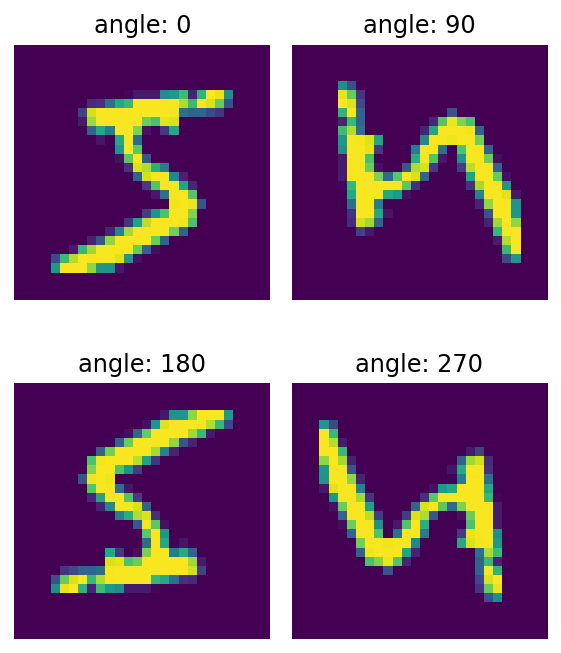

In [13]:
degrees = [0, 90, 180, 270]

fig, ax = plt.subplots(2, 2, figsize=(4, 5))
for axi, deg in zip(ax.flat, degrees):
    x_shift = processor(X_train[0], deg)
    
    axi.imshow(x_shift)
    axi.axis("off")
    axi.set_title(f"angle: {deg}")
plt.tight_layout()

In [14]:
key = jax.random.PRNGKey(314)

batch_size = 2000
n_epochs = 50
alpha = 0.005
tx = optax.adam(learning_rate=alpha)
# tx = optax.cosine_decay_schedule(0.1, 10)
model = gendist.models.MLPDataV1(n_classes)
# model = gendist.models.LeNet5(n_classes)

proc_class = gendist.processing.Factory(processor)
# degrees = np.r_[np.linspace(0, 90, 50), np.linspace(180, 270, 50)]
degrees = np.linspace(0, 360, 150)

In [15]:
num_cycles = 10
epochs_per_cycle = 50
batch_size = 2_000
n_epochs = num_cycles * epochs_per_cycle
steps_per_epoch = X_train.shape[0] // batch_size
boundaries = list(np.arange(1, num_cycles + 1) * epochs_per_cycle * steps_per_epoch)
n_epochs

500

In [16]:
alpha0 = 0.02 # 0.085
alphas = [alpha0 for n in range(n_epochs)]
cycle_size = epochs_per_cycle * steps_per_epoch
learning_rates = [optax.cosine_decay_schedule(alpha, cycle_size, 0.0) for alpha in alphas]
learning_rates = optax.join_schedules(learning_rates, boundaries)

In [17]:
tx = optax.adam(learning_rates)

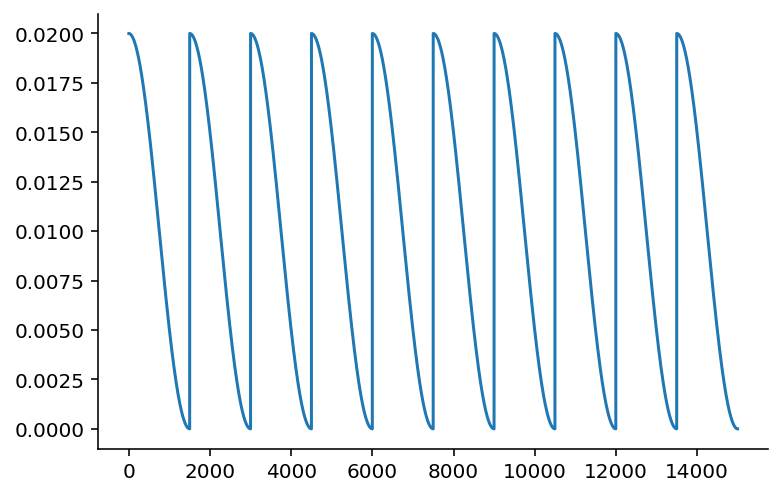

In [18]:
steps = jnp.arange(n_epochs * steps_per_epoch)
plt.plot(steps, learning_rates(steps))

In [94]:
config = {"angle": 0.0}
train_config = gendist.training.TrainingSnapshot(model, proc_class,
                              gendist.training.make_cross_entropy_loss_func, tx, epochs_per_cycle)
def eval_acc(y, yhat):
    return (y.argmax(axis=1) == yhat.argmax(axis=1)).mean().item()
    
train_output = train_config.fit(key, X_train, y_train_ohe, config, n_epochs, batch_size, eval_acc)

In [95]:
train_output["losses"][:100]

DeviceArray([2.65338993e+00, 1.78892389e-01, 1.19865194e-01,
             9.86842215e-02, 7.61504024e-02, 6.22865111e-02,
             5.92334419e-02, 5.09617031e-02, 4.34103720e-02,
             3.68547738e-02, 3.91100422e-02, 3.29111293e-02,
             2.82074120e-02, 1.99554749e-02, 1.58561617e-02,
             1.26977675e-02, 1.15931835e-02, 9.58558638e-03,
             7.55568687e-03, 5.43169072e-03, 4.94409306e-03,
             3.99523927e-03, 2.23343261e-03, 1.44241739e-03,
             9.39719554e-04, 6.69622445e-04, 5.20206231e-04,
             4.64100565e-04, 4.15332615e-04, 3.67220695e-04,
             3.50085320e-04, 3.27428046e-04, 3.03390407e-04,
             2.89907795e-04, 2.77868268e-04, 2.66096235e-04,
             2.57718464e-04, 2.52383732e-04, 2.43594477e-04,
             2.37918241e-04, 2.33675586e-04, 2.29946934e-04,
             2.27048833e-04, 2.24890406e-04, 2.22863295e-04,
             2.21853828e-04, 2.20786736e-04, 2.20141126e-04,
             2.19792681e

(0.0, 0.3)

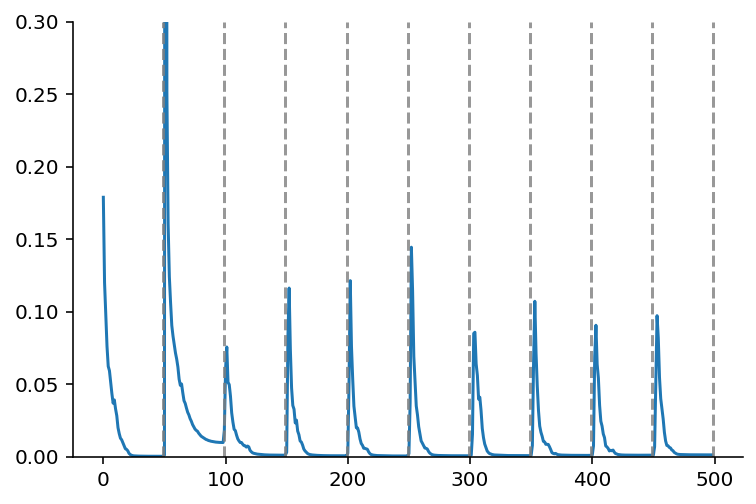

In [96]:
plt.plot(train_output["losses"][1:])
for boundary in boundaries:
    plt.axvline(x=boundary / steps_per_epoch - 1, c="tab:gray", alpha=0.8, linestyle="--")
plt.ylim(0, 0.3)

In [ ]:
train_config = gendist.training.TrainingSnapshot(model, proc_class,
                              gendist.training.make_cross_entropy_loss_func, tx, epochs_per_cycle)
configs_params = []
configs_losses = []
configs_metrics = []

for deg in tqdm(degrees):
    config = {"angle": float(deg)}
    train_output = train_config.fit(key, X_train, y_train_ohe, config, n_epochs, batch_size, eval_acc)
    
    collection_params = train_output["params"]
    losses = train_output["losses"]
    metrics = train_output["metrics"]
    
    configs_params.extend(collection_params)
    configs_losses.append(losses)
    configs_metrics.append(metrics)

(0.0, 0.25)

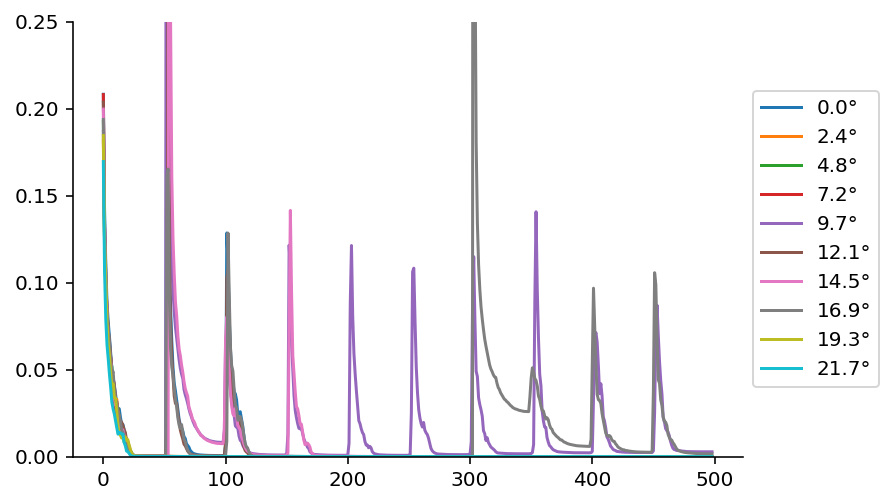

In [109]:
np.random.seed(31415)
n_configurations = len(degrees)
n_samples = 10
sample_configs = np.random.randint(0, n_configurations, size=n_samples)


fig, ax = plt.subplots()
for deg, config_ix in zip(degrees, sample_configs):
    plt.plot(configs_losses[config_ix][1:], label=f"{deg:0.1f}°")
plt.legend()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylim(0, 0.25)

In [101]:
filename = "data-params.pkl"
filename = os.path.join(path_output, filename)

output_elements = {
    "configs": degrees,
    "params": configs_params,
    "metric": configs_losses
}

with open(filename, "wb") as f:
    pickle.dump(output_elements, f)

In [19]:
filename = "data-params.pkl"
filename = os.path.join(path_output, filename)

with open(filename, "rb") as f:
    output_elements = pickle.load(f)

    degrees = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_losses = output_elements["metric"]

In [20]:
cpus = jax.devices("cpu")
configs_params_cpu = jax.device_put(configs_params, cpus[0])
configs_params_flat, fn_recontruct_params = gendist.processing.flat_and_concat_params(configs_params_cpu)

tcmalloc: large alloc 6201065472 bytes == 0x562b40abc000 @  0x7f3c8f59f680 0x7f3c8f5c0824 0x7f3c8f5c0b8a 0x7f3c84562424 0x7f3c7f5d08ef 0x7f3c7f5db1cc 0x7f3c7f5de1b7 0x7f3c7f52dc77 0x7f3c7f2694e8 0x7f3c7f24daaa 0x562358621e64 0x56235861be4f 0x5623585afd94 0x5623585da1ca 0x562358661d2b 0x562358662697 0x56235855b556 0x56235857d348 0x56235861b788 0x5623586a97e0 0x562358661d2b 0x562358662697 0x56235861b788 0x5623586a97e0 0x562358661b32 0x562358662697 0x56235855b556 0x5623586feede 0x56235861b687 0x5623586a97e0 0x5623586628c3


In [21]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(configs_params_flat)

tcmalloc: large alloc 6201065472 bytes == 0x562cb2c88000 @  0x7f3c8f59f680 0x7f3c8f5c0824 0x7f3c6d22b1ed 0x7f3c6d22b267 0x7f3c6d26dc1b 0x7f3c6d26df8a 0x7f3c6d265c85 0x7f3c6d307764 0x56235861fa41 0x5623585d9f00 0x562358661d2b 0x562358662697 0x56235861b687 0x5623586a97e0 0x56235868d3fd 0x5623585d9f00 0x5623586628c3 0x5623585da1a4 0x562358661b32 0x562358662697 0x5623585da1a4 0x562358661b32 0x562358711ddc 0x562358662b5b 0x5623587478fe 0x562358640581 0x5623585da3be 0x562358652d34 0x5623586ac3ff 0x562358652d34 0x5623586ac3ff
tcmalloc: large alloc 6201065472 bytes == 0x562e24654000 @  0x7f3c8f59f680 0x7f3c8f5c0824 0x7f3c6d22b1ed 0x7f3c6d22b267 0x7f3c6d26dc1b 0x7f3c6d26ded8 0x7f3c6d31f177 0x7f3c6d320dec 0x7f3c6d466652 0x56235857fe88 0x5623587015d8 0x7f3c6d3280a7 0x562358616829 0x5623586a8280 0x562358661d2b 0x562358662697 0x56235861b687 0x5623586a97e0 0x562358661d2b 0x562358662697 0x56235861b687 0x7f3c6d25aa74 0x562358621e88 0x56235861be4f 0x5623586a7937 0x562358661b32 0x562358662697 0x5623585d

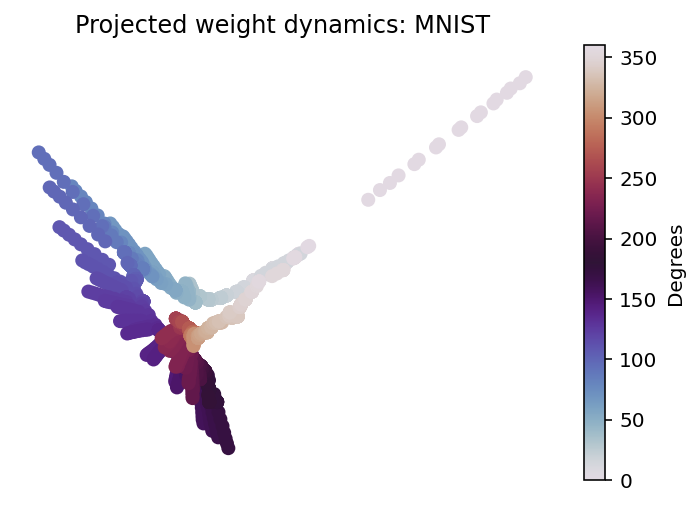

In [22]:
fig, ax = plt.subplots()

degrees_ravel = (degrees[:, None] * np.ones((1, 10))).ravel()

ax.set_title("Projected weight dynamics: MNIST")
im =  ax.scatter(*params_proj.T, cmap="twilight", c=degrees_ravel)
fig.colorbar(im, ax=ax, label="Degrees")

ax.tick_params(axis="both", labelleft=False, labelbottom=False)
ax.axis("equal")
ax.axis("off");

## Training weights

In [23]:
n_components = 60
pca = PCA(n_components=n_components)
params_proj = pca.fit_transform(configs_params_flat)

tcmalloc: large alloc 6201065472 bytes == 0x562cb2c88000 @  0x7f3c8f59f680 0x7f3c8f5c0824 0x7f3c6d22b1ed 0x7f3c6d22b267 0x7f3c6d26dc1b 0x7f3c6d26df8a 0x7f3c6d265c85 0x7f3c6d307764 0x56235861fa41 0x5623585d9f00 0x562358661d2b 0x562358662697 0x56235861b687 0x5623586a97e0 0x56235868d3fd 0x5623585d9f00 0x5623586628c3 0x5623585da1a4 0x562358661b32 0x562358662697 0x5623585da1a4 0x562358661b32 0x562358711ddc 0x562358662b5b 0x5623587478fe 0x562358640581 0x5623585da3be 0x562358652d34 0x5623586ac3ff 0x562358652d34 0x5623586ac3ff
tcmalloc: large alloc 6201065472 bytes == 0x562e24654000 @  0x7f3c8f59f680 0x7f3c8f5c0824 0x7f3c6d22b1ed 0x7f3c6d22b267 0x7f3c6d26dc1b 0x7f3c6d26ded8 0x7f3c6d31f177 0x7f3c6d320dec 0x7f3c6d466652 0x56235857fe88 0x5623587015d8 0x7f3c6d3280a7 0x562358616829 0x5623586a8280 0x562358661d2b 0x562358662697 0x56235861b687 0x5623586a97e0 0x562358661d2b 0x562358662697 0x56235861b687 0x7f3c6d25aa74 0x562358621e88 0x56235861be4f 0x5623586a7937 0x562358661b32 0x562358662697 0x5623585d

In [24]:
angle_dict = [{"angle": float(deg)} for deg in degrees]

In [25]:
n_train_subset = 6_000
subset_ix = pd.Series(y_train).sample(n_train_subset, random_state=314)
subset_ix = subset_ix.index.values
subset_ix

array([46242, 52277, 30471, ..., 18692,  3212,   220])

In [26]:
n_train, *elem_dims = X_train.shape
n_configs = len(degrees)

imap = np.ones((n_configs, 1, *elem_dims))
X_train_shift = X_train[subset_ix] * imap
X_train_shift = X_train_shift.reshape(-1, *elem_dims)
X_train_shift.shape

tcmalloc: large alloc 5644804096 bytes == 0x5627008bc000 @  0x7f3c8f59f680 0x7f3c8f5c0824 0x7f3c6d22b1ed 0x7f3c6d22b267 0x7f3c6d26dc1b 0x7f3c6d26ded8 0x7f3c6d31f177 0x7f3c6d320dec 0x7f3c6d466652 0x56235857fe88 0x5623587015d8 0x7f3c6d327ff7 0x56235866d520 0x5623586a8568 0x562358661b32 0x562358711ddc 0x562358662b5b 0x5623587478fe 0x562358640581 0x5623585da3be 0x562358652d34 0x5623586ac3ff 0x562358652d34 0x5623586ac3ff 0x562358652d34 0x56235865c0a3 0x5623585da1a4 0x5623586628c3 0x5623585da3be 0x5623586628c3 0x5623585da1a4


(900000, 28, 28)

In [27]:
degrees_shift = (degrees_ravel[:, None] * np.ones((1, 600))).reshape(-1)

degrees_shift = [{"angle": float(angle)} for angle in degrees_shift] # degrees_shift

X_train_shift = proc_class(X_train_shift, degrees_shift)

tcmalloc: large alloc 2822406144 bytes == 0x5629ce822000 @  0x7f3c8f59f680 0x7f3c8f5c0824 0x7f3c6d22b1ed 0x7f3c6d22b267 0x7f3c6d26dc1b 0x7f3c6d30ab5e 0x7f3c6d30b37a 0x7f3c6d30b5ae 0x562358621e64 0x56235861b7e4 0x7f3c6d25aa74 0x562358621e88 0x56235861be4f 0x5623586a7937 0x562358661b32 0x562358662697 0x5623585d9f00 0x5623586628c3 0x5623585da1a4 0x562358661b32 0x562358662697 0x56235865260a 0x5623586529d5 0x56235861be4f 0x5623586a7937 0x562358661b32 0x562358711ddc 0x562358662b5b 0x5623587478fe 0x562358640581 0x5623585da3be


In [28]:
X_train_shift = X_train_shift.reshape((n_train_subset, n_configs, -1), order="F")
y_train_shift = params_proj.reshape((num_cycles, n_configs, -1), order="F")

In [29]:
X_train_shift.shape

(6000, 150, 784)

In [30]:
y_train_shift.shape

(10, 150, 60)

In [31]:
X_train_shift_jax = jnp.array(X_train_shift)
y_train_shift_jax = jnp.array(y_train_shift)

tcmalloc: large alloc 2822406144 bytes == 0x5625808c6000 @  0x7f3c8f59f680 0x7f3c8f5c0824 0x7f3c8f5c0b8a 0x7f3c84562424 0x7f3c810a9b8e 0x7f3c7f531edf 0x7f3c7f52e9d0 0x7f3c7f535b72 0x7f3c7f5266b3 0x7f3c7f255abd 0x7f3c7f24daaa 0x562358621e64 0x56235861be4f 0x5623585afd94 0x5623585da1ca 0x5623586628c3 0x5623585da3be 0x562358661b32 0x562358662697 0x5623585da3be 0x562358661d2b 0x562358662697 0x5623585da3be 0x562358661d2b 0x562358662697 0x56235855b556 0x56235857d348 0x56235861b788 0x5623586a97e0 0x562358661d2b 0x562358662697
tcmalloc: large alloc 2829926400 bytes == 0x56288447c000 @  0x7f3c8f59f680 0x7f3c8f5c0824 0x7f3c78579e11 0x7f3c7857a551 0x7f3c794fa5df 0x7f3c794fb0da 0x7f3c78591586 0x7f3c7db77dd5 0x7f3c7db733c7 0x7f3c7db6d485 0x7f3c7858d730 0x7f3c7857cfb5 0x7f3c83b28130 0x7f3c810a4dea 0x7f3c8455fa61 0x7f3c8455d413 0x7f3c8453ecf5 0x7f3c8f409609 0x7f3c8f32e163


In [32]:
alpha = 0.005
n_epochs = 50
batch_size = 2000
tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_multi_output_loss_func
weights_model = gendist.models.MLPWeightsV1(n_components)
train_weights = gendist.training.TrainingMeta(weights_model, lossfn, tx)

In [33]:
meta_output = train_weights.fit(key, X_train_shift_jax, y_train_shift_jax[[2], ...], n_epochs, batch_size)

In [34]:
yhat_train_shift = weights_model.apply(meta_output["params"], X_train_shift_jax)

In [35]:
yhat_train_shift.shape

(6000, 150, 60)

In [39]:
jnp.power(yhat_train_shift[::600] - y_train_shift_jax, 2).mean(axis=0).mean(axis=0)

DeviceArray([194.79747 , 151.4534  , 106.40813 , 113.88715 , 155.23073 ,
             120.08874 , 124.2705  , 161.96254 , 170.32509 , 184.44785 ,
             126.950836, 170.46323 , 124.86776 , 114.324326, 126.14103 ,
             120.76096 , 127.22737 , 110.29461 , 119.85928 , 114.063126,
             277.52887 , 138.91127 , 119.746666, 106.479256, 110.61564 ,
             109.872284, 120.59852 ,  93.33284 , 109.76105 ,  89.96784 ,
              90.24489 , 100.425446, 111.99017 ,  96.10067 , 102.80885 ,
              97.59138 ,  97.43576 ,  94.74083 ,  84.26453 , 103.607025,
             105.44535 , 101.575966,  93.73409 , 100.115234,  93.13654 ,
              83.22852 ,  83.69967 ,  91.01522 , 102.12922 , 107.22017 ,
              88.25449 , 124.69387 ,  71.2603  ,  83.12568 ,  97.826256,
              95.69621 ,  92.423325,  67.486   ,  68.83236 ,  68.16002 ],            dtype=float32)

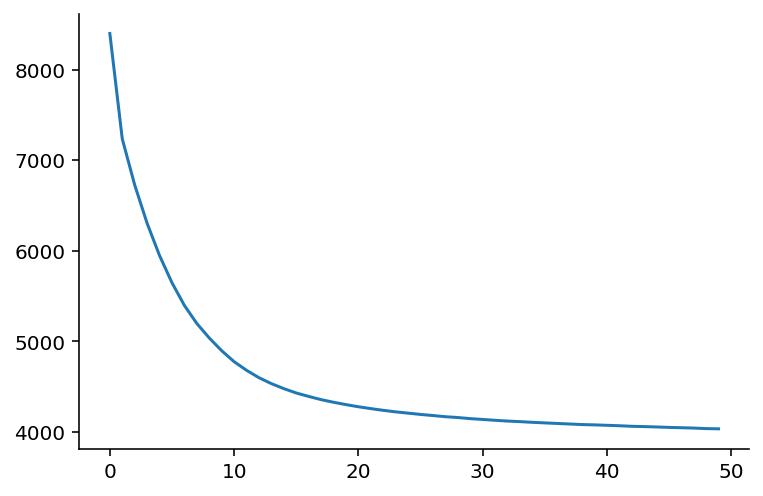

In [37]:
weights_trained = meta_output["params"]
losses = meta_output["losses"]

plt.plot(losses)

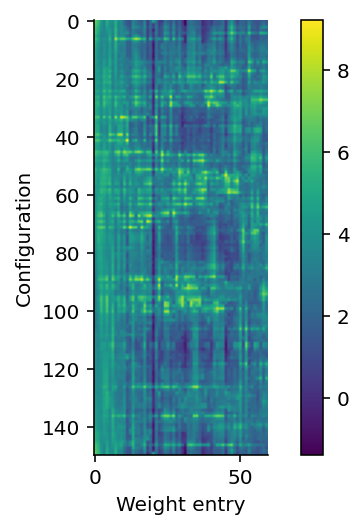

In [125]:
errs = np.power((weights_model.apply(weights_trained, X_train_shift_jax) - y_train_shift_jax[[0], :]), 2).mean(axis=0)
plt.imshow(jnp.log(errs))
plt.ylabel("Configuration")
plt.xlabel("Weight entry")
plt.colorbar()

In [132]:
from itertools import product

In [280]:
N, M, K = 4, 3, 1
tot_values = N * M * K
batch_ix = np.arange(tot_values)
batch_ix % K

X_obs = np.array([f"x({n},{m})" for n, m in product(range(N), range(M))]).reshape(N, M)
w_obs = np.array([f"w({k},{m})" for k, m in product(range(K), range(M))]).reshape(K, M)

In [281]:
X_obs

array([['x(0,0)', 'x(0,1)', 'x(0,2)'],
       ['x(1,0)', 'x(1,1)', 'x(1,2)'],
       ['x(2,0)', 'x(2,1)', 'x(2,2)'],
       ['x(3,0)', 'x(3,1)', 'x(3,2)']], dtype='<U6')

In [282]:
w_obs

array([['w(0,0)', 'w(0,1)', 'w(0,2)']], dtype='<U6')

In [283]:
x_batch_str = X_obs[batch_ix % N, batch_ix // (N * K)]
w_batch_str = w_obs[(batch_ix // N) % K, batch_ix // (N * K)]

for x, w in zip(x_batch_str, w_batch_str):
    print(x, w)

x(0,0) w(0,0)
x(1,0) w(0,0)
x(2,0) w(0,0)
x(3,0) w(0,0)
x(0,1) w(0,1)
x(1,1) w(0,1)
x(2,1) w(0,1)
x(3,1) w(0,1)
x(0,2) w(0,2)
x(1,2) w(0,2)
x(2,2) w(0,2)
x(3,2) w(0,2)


In [163]:
jnp.power(weights_model.apply(weights_trained, X_train_shift) - y_train_shift, 2).mean()

DeviceArray(11.283924, dtype=float32)

In [254]:
filename = "projected-weights.params"
filename = os.path.join(path_output, filename)

with open(filename, "wb") as f:
    bytes_params = serialization.to_bytes(weights_trained)
    f.write(bytes_params)

# Proxy zero-shot learning

In [255]:
angle_test = np.linspace(0, 360, 100)

In [23]:
with open(observed_space_filename, "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

In [24]:
with open("weights-dynamics-rotation-trench.params", "rb") as f:
    weights_trained = weights_model.init(jax.random.PRNGKey(314), jnp.ones((1, 28 ** 2)))
    weights_trained = serialization.from_bytes(weights_trained, f.read())

In [256]:
logger.remove()
filename = f"trench-test-c{n_components}.log"
filename = os.path.join(path_logs, filename)
logger.add(filename, rotation="5mb")

1

In [257]:
def predict_shifted_dataset(ix_seed, X_batch, processor, config, wmodel, wparams, dmodel, proj, fn_reconstruct):
    """
    Parameters
    ----------
    ix_seed: array
    X_batch: array
    ...
    wmodel: model for the latent space
    wparams: trained weights for the latent space
    dmodel: model for the observed space
    dparams: trained model for the observed weights
    """
    x_seed = X_batch[ix]
    x_shift = processor.process_single(x_seed, **config).ravel()
    predicted_weights = wmodel.apply(wparams, x_shift)
    predicted_weights = proj.inverse_transform(predicted_weights)
    predicted_weights = fn_reconstruct(predicted_weights)
    
    X_batch_shift = processor(X_batch, config)
    y_batch_hat = dmodel.apply(predicted_weights, X_batch_shift)
    
    return y_batch_hat

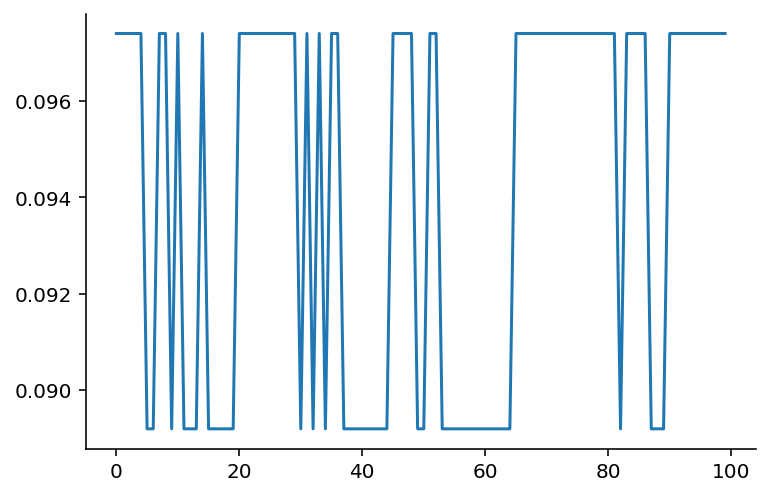

In [264]:
plt.plot(accuracy_configs_learned)

In [260]:
ix = 4
accuracy_configs_learned = []
predicted_weights_array = []

for angle in tqdm(angle_test):
    config = {"angle": float(angle)}
    
    y_test_hat = predict_shifted_dataset(ix, X_test, proc_class, config,
                                         weights_model, weights_trained, model, pca, fn_recontruct_params)
    y_test_hat = y_test_hat.argmax(axis=1)
    
    accuracy_learned = (y_test_hat == y_test).mean()
    accuracy_configs_learned.append(accuracy_learned.item())
    
    # predicted_weights_array.append(predicted_weights)
    
    logger.info(f"{angle=:0.4f} | {accuracy_learned=:0.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

https://symbolize.stripped_domain/r/?trace=55d2fbf5b5c0,7f3bc72283bf,7f392d5ac4ef,55d2fc118c1f&map= 
*** SIGTERM received by PID 2339768 (TID 2339768) on cpu 31 from PID 2236720; stack trace: ***
PC: @     0x55d2fbf5b5c0  (unknown)  PyObject_SetAttr
    @     0x7f3bb6ad67fa        992  (unknown)
    @     0x7f3bc72283c0  (unknown)  (unknown)
    @     0x7f392d5ac4f0  1811511240  (unknown)
    @     0x55d2fc118c20  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=55d2fbf5b5c0,7f3bb6ad67f9,7f3bc72283bf,7f392d5ac4ef,55d2fc118c1f&map=7a511a57244151c993b16b37978e7ed7:7f3ba80fe000-7f3bb6e40d50 
E0318 17:04:32.452300 2339768 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0318 17:04:32.508304 2339768 process_state.cc:770] RAW: Raising signal 15 with default behavior
https://symbolize.stripped_domain/r/?trace=55d2fbeb6700,7f3bc72283bf,55d2fcbc5fff&map= 
*** SIGTERM received by PID 2347413 (TID 2347413) on cpu 5 from PID 2236720; stack trace: ***
PC: @   

In [ ]:
accuracy_configs_learned = []
predicted_weights_array = []

ixs = [0, 1, 2, 3, 4]
for angle in tqdm(angle_test):
    config = {"angle": float(angle)}
    
    acc_dict = {}
    params_dict = {}
    for ix in ixs:
        y_test_hat = predict_shifted_dataset(ix, X_test, proc_class, config,
                                             weights_model, weights_trained, model, pca, fn_recontruct_params)
        y_test_hat = y_test_hat.argmax(axis=1)
        accuracy_learned = (y_test_hat == y_test).mean().item()
        acc_dict[ix] = accuracy_learned
        
    accuracy_configs_learned.append(acc_dict)
    
    logger_row = "|".join([format(v, "0.2%") for v in acc_dict.values()])
    logger_row = f"{angle=:0.4f} | " + logger_row 
    
    logger.info(logger_row)

  0%|          | 0/100 [00:00<?, ?it/s]

https://symbolize.stripped_domain/r/?trace=7f36d8b81a65,7f36d8b833bf&map= 
*** SIGTERM received by PID 2028279 (TID 2028279) on cpu 31 from PID 1951196; stack trace: ***
https://symbolize.stripped_domain/r/?trace=7f36d8b81a65,7f36d8b833bf&map= 
*** SIGTERM received by PID 2028269 (TID 2028269) on cpu 84 from PID 1951196; stack trace: ***
PC: @     0x7f36d8b81a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f36c6e317fa        992  (unknown)
    @     0x7f36d8b833c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=7f36d8b81a65,7f36c6e317f9,7f36d8b833bf&map=7a511a57244151c993b16b37978e7ed7:7f36b8459000-7f36c719bd50 
E0315 13:27:38.786079 2028279 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
PC: @     0x7f36d8b81a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f36c6e317fa        992  (unknown)
    @     0x7f36d8b833c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domai

In [ ]:
acc_df = pd.DataFrame(accuracy_configs_learned, index=angle_test, columns=y_test[ixs])
acc_df.plot()

plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.axvspan(90, 180, alpha=0.2, color="tab:gray")

plt.axvline(x=270, c="tab:gray", linestyle="--")
plt.axvline(x=360, c="tab:gray", linestyle="--")
plt.axvspan(270, 360, alpha=0.2, color="tab:gray")


We evaluate the predicted weights on the training dataset

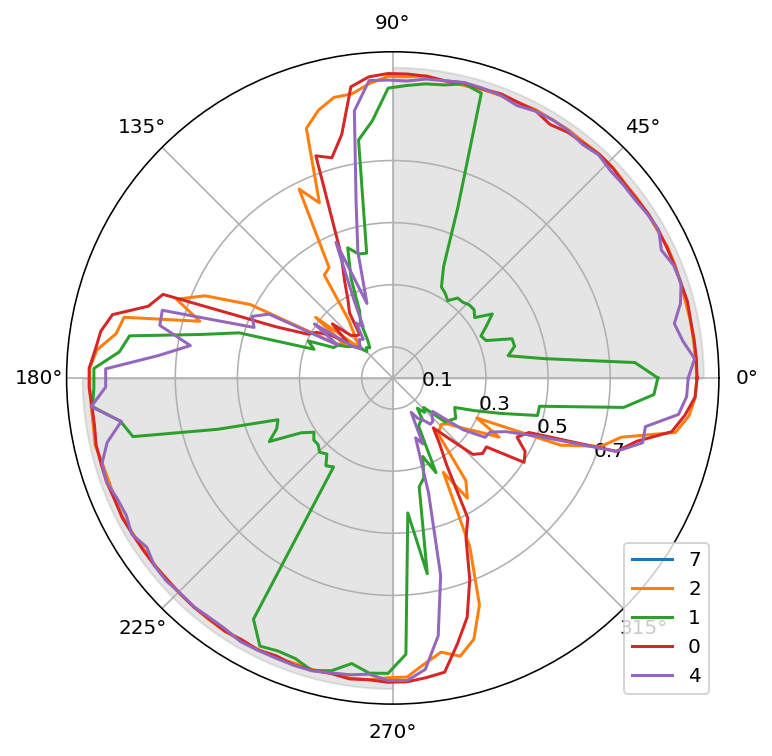

In [247]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 6))
acc_df.set_index(acc_df.index.values * np.pi / 180).plot(ax=ax)
ax.set_rticks([0.1, 0.3, 0.5, 0.7])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.fill_between(np.linspace(0, np.pi/2, 100), 0, 1.0, alpha=0.2, color="tab:gray")
ax.fill_between(np.linspace(np.pi, 3 * np.pi/2, 100), 0, 1.0, alpha=0.2, color="tab:gray")
plt.legend(loc="lower right")

ax.grid(True)